# Image Classification: Pistachios

## MIDS W281: Computer Vision, Summer 2022

### Team members: Blake Bormes, Yu (Albert) Jiang, Deva Kulkarni

## Introduction

The focus of this project is to apply various computer vision techniques to classify images of pistachios. The dataset used in this project is made available on kaggle.com[1]. This dataset contains a total of 2148 images of two major types of pistachios grown in turkey, namely Kirmizi and Siirt. Since the prices, tastes, and nutritional values of these types differs, the type of pistachio becomes important when it comes to trade[2]. The dataset includes 1232 images of Kirmizi pistachios and 916 of Siirt Pistachios. 

The following report describes the Exploratory Data Analysis, Feature Extraction, Principal Component Analysis and Classification steps performed through the course of this project.



## Imports

In [2]:
#Importing libraries
import os

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import seaborn as sns
from scipy.cluster.vq import vq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import spatial

## Load data

In [3]:
# csv file with pistachio names and labels
csv = pd.read_csv('pistachios_initial.csv', index_col = 0)

In [4]:
# pistachio_type 1 is Kirmizi, pistachio_type 0 is Siirt
csv.head()

,filename,filename_camelcase,pistachio_type
0,kirmizi (23).jpg,kirmizi_23.jpg,0
1,kirmizi 21.jpg,kirmizi_21.jpg,0
2,kirmizi 35.jpg,kirmizi_35.jpg,0
3,kirmizi 475.jpg,kirmizi_475.jpg,0
4,kirmizi 313.jpg,kirmizi_313.jpg,0


In [5]:
csv.pistachio_type.value_counts()

0    1232
1     916
Name: pistachio_type, dtype: int64

In [6]:
images = [] #list of images

for fname in csv.filename.values:
    if "kirm" in fname:
        fname = "Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/{}".format(fname)
    else:
        fname = "Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio/{}".format(fname)
        
    images.append(plt.imread(fname))


print('Total number of images: {}'.format(len(images)))
print('Shape of each image: {}'.format(images[0].shape))

Total number of images: 2148
Shape of each image: (600, 600, 3)


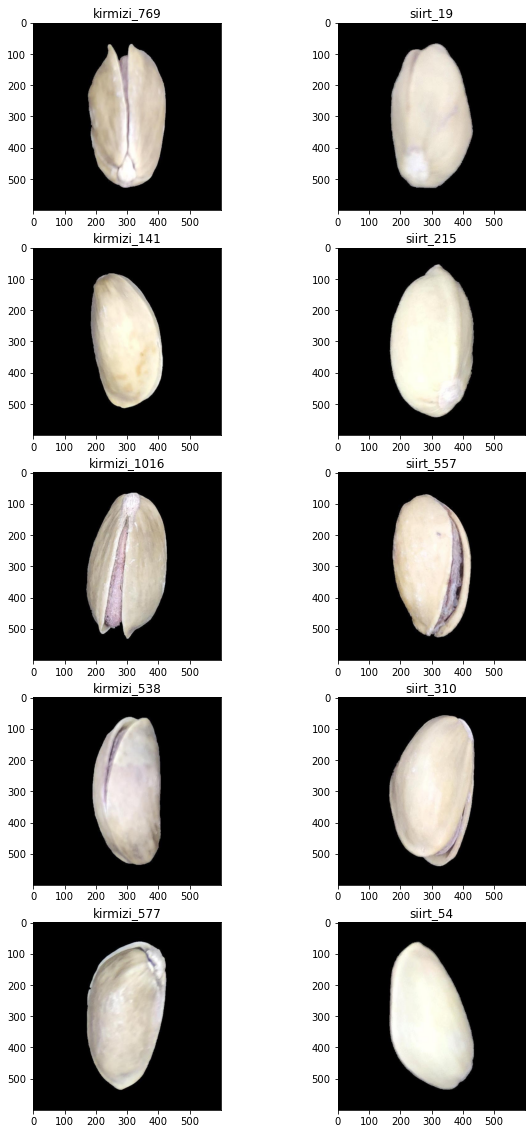

In [7]:
#Create list of random indexes to display random images
low = csv.pistachio_type.value_counts()[0]
high = csv.pistachio_type.value_counts()[1]
random.seed(123)
random_image_index_kirmizi = np.random.randint(low, size=5)
random_image_index_siirt = np.random.randint(low + 1, low + high +1, size=5)


# Display examples images
fig, ax = plt.subplots(len(random_image_index_kirmizi),2, figsize = (10, 20))

for j, (index_0, index_1) in enumerate(zip(random_image_index_kirmizi, random_image_index_siirt)):
    
    ax[j, 0].imshow(images[index_0])
    ax[j, 0].set_title(csv.filename_camelcase[index_0][:-4])
    
    ax[j, 1].imshow(images[index_1])
    ax[j, 1].set_title(csv.filename_camelcase[index_1][:-4])      
        

Through simple visual inpsection, we see that Kirmizi pistachio (type 0) tend to be smaller than Siirt pistachios (type 1) on average. Kirmizi pistachios also tend to be longer and more slender than Siirt pistachios. There doesn't seem to be a clear difference in the shell or nut colors of the pistachios.

## EDA and Feature Extraction

- We look at the percentage of the image covered by the pistachio. We see that there is some separation between the two classes for this variable, with type 0 pistachios being slightly smaller than type 1 pistachios.

In [8]:
# Convert images to grayscale, and calculate the percentage area covered by the pistachio
grey_images = []
for img in images:
    grey_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

percent_area = []
for img in grey_images:
    percent_area.append(np.count_nonzero(img)/(img.shape[0]*img.shape[1]))

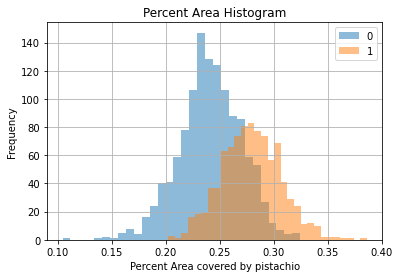

In [9]:
# Plot percent area for the two labels
csv['percent_area'] = percent_area

plt.hist(csv[csv.pistachio_type == 0].percent_area, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].percent_area, bins = 30, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Percent Area covered by pistachio')
plt.ylabel('Frequency')
plt.title('Percent Area Histogram')
plt.show()

- We fit an ellipse to the outer edges of the pistachio image. Using the fitted ellipse, we calculate the major axis, minor axis, area and perimeter. We further use these parameters to calculate eccentricity, equivalent diameter, extent, aspect ratio, compactness, roundness and four shape factors as defined below

***Add definitions of variables***

***Add code for fitting ellipse***

***Show sample images with pisatchio and fitted ellipse and major/minor axes***

***Maybe some plots showing distributions of some of the variables between the two classes?***

- To quantify the fit of the ellipse to the outer edges of the pisatchio, we calculate the distance of each point on the pistachio edge from the fitted ellipse. The final feature is the sum of all the distances for each pistachio scaled by the perimeter of the ellipse.

In [10]:
#Rescale and blur
rescaled_images = []
for img in grey_images:
    rescaled_images.append(cv2.GaussianBlur(cv2.resize(img, (200, 200)), (9, 9), 0))

def fit_ellipse(img):
    '''This function takes in an image of a pistachio and fits an ellipse to its outer edges.
    '''
    out_img = img.copy()            
    
    try:
        
        ret,thresh = cv2.threshold(out_img,5,255,0)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        
        cnt = contours[-1]
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt,True)
        ellipse = cv2.fitEllipse(cnt)
        return cv2.ellipse(out_img,ellipse,(255),2), cv2.ellipse(np.zeros_like(out_img),ellipse,(255),1), ellipse

    except cv2.error as e:
        pass

#Fit ellipse
ellipse_images = []
for img in rescaled_images:
    ellipse_images.append(fit_ellipse(img))
    
    
#Detect edges
def whiten_image(img):
    '''Take a rescaled and blurred image of pistachio, blow up pistachio to white,
    detect edges and return.
    '''    
    out_img = img.copy()
    
    out_img = np.where(out_img > 5, 255, 0).astype('uint8')
    
    return cv2.Canny(out_img, 100, 200)


white_patch_edge_detect = []
for img in rescaled_images:
    white_patch_edge_detect.append(whiten_image(img))


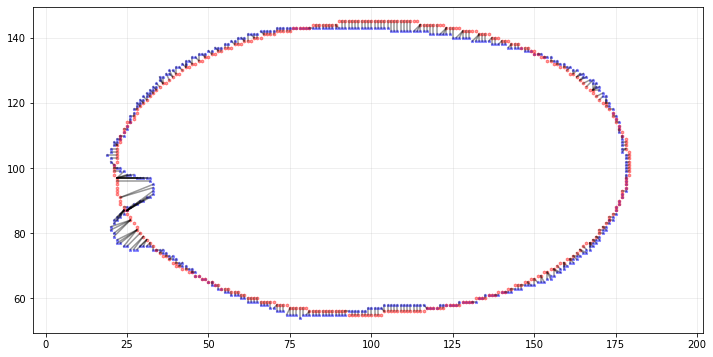

In [11]:
# Detect pistachio edge
pistachio_edge = np.argwhere(white_patch_edge_detect[random_image_index_kirmizi[0]] == 255)

# Detect ellipse 
ellipse_boundary = np.argwhere(ellipse_images[random_image_index_kirmizi[0]][1] == 255)

# For each point in pistachio_edge, find the closest point in ellipse_boundary:
code, dist = vq(pistachio_edge, ellipse_boundary)

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.plot(pistachio_edge[:,0], pistachio_edge[:,1], 'b*', markersize=3, alpha=0.4)
plt.plot(ellipse_boundary[:,0], ellipse_boundary[:,1], 'rh', markersize=3, alpha=0.4)

for i, j in enumerate(code):
    plt.plot([pistachio_edge[i,0], ellipse_boundary[j,0]],
             [pistachio_edge[i,1], ellipse_boundary[j,1]], 'k', alpha=0.4)

plt.grid(True, alpha=0.25)
plt.axis('equal')
plt.show()

In [12]:
def calculate_distance(ellipse_img, edge_img):
    '''This function calcualtes the minimum distance between points on 
    the edge image and points on the ellipse image. Returns total disstance normalized by ellipse perimeter
    '''
    edge_points = np.argwhere(edge_img == 255)
    ellipse_points = np.argwhere(ellipse_img[1] == 255)
    
       
    code, dist = vq(edge_points, ellipse_points)
    
    return dist.sum()/calculate_perimeter(ellipse_img[2][1][0], ellipse_img[2][1][1])
    
def calculate_perimeter(a,b):
    perimeter = np.pi * ( 3*(a+b) - np.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

In [13]:
distance_from_ellipse = []
for i in range(len(images)):
    try:
        distance_from_ellipse.append(calculate_distance(ellipse_images[i], white_patch_edge_detect[i]))
    except:
        print(i)
        distance_from_ellipse.append(np.nan)

In [14]:
csv['distance_from_ellipse'] = distance_from_ellipse

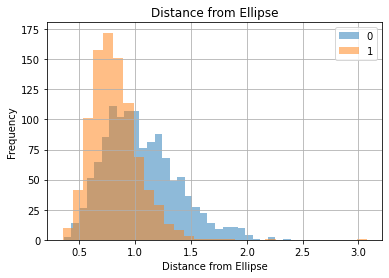

In [15]:
plt.hist(csv[csv.pistachio_type == 0].distance_from_ellipse, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].distance_from_ellipse, bins = 30, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Distance from Ellipse')
plt.ylabel('Frequency')
plt.title('Distance from Ellipse')
plt.show()

We see that the distance of ellipse parameter does show some separation between the two classes. The ellipses tend to fit better ot type 1 pistachios than type 2 pistachios on average.

- We also look at the color data from each image. Specifically, we calculate the mean and median values for the pixels that depict the pistachio. We also calculate the mean and median value for each channel of the pistachio. In addition, we use k means clustering to separate the pixels into clusters that depict the pistachio shell and the pistachio nut and take the mean and median values for those

***Add code and plots showing color stuff**

### Learned features

### PCA analysis



In [155]:
#Importing hand coded and learned features from saved csv files.

# check if train, val, and test data already exist
if os.path.exists("pistachios_with_cnn_train.csv"):
    # if so, read them directly
    X_train = pd.read_csv("pistachios_with_cnn_train.csv", index_col=0)
    y_train = pd.read_csv("pistachios_with_cnn_train_labels.csv", index_col=0, squeeze=True)
    X_val = pd.read_csv("pistachios_with_cnn_val.csv", index_col=0)
    y_val = pd.read_csv("pistachios_with_cnn_val_labels.csv", index_col=0, squeeze=True)
    X_test = pd.read_csv("pistachios_with_cnn_test.csv", index_col=0)
    y_test = pd.read_csv("pistachios_with_cnn_test_labels.csv", index_col=0, squeeze=True)
else:
    # otherwise, read in the main data frame and split into train, val, and test
    df = pd.read_csv("pistachios_with_cnn.csv")
    X = df[df.columns[4:]]
    y = df["pistachio_type"]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

    # save train, val, and test for future use
    X_train.to_csv("pistachios_with_cnn_train.csv")
    y_train.to_csv("pistachios_with_cnn_train_labels.csv")
    X_val.to_csv("pistachios_with_cnn_val.csv")
    y_val.to_csv("pistachios_with_cnn_val_labels.csv")
    X_test.to_csv("pistachios_with_cnn_test.csv")
    y_test.to_csv("pistachios_with_cnn_test_labels.csv")

# separate hand coded features from the cnn features for train, val, and test
X_train_cnn = X_train[X_train.columns[-8:]].copy()
X_val_cnn = X_val[X_val.columns[-8:]].copy()
X_test_cnn = X_test[X_test.columns[-8:]].copy()
X_train.drop(X_train.columns[-8:], inplace=True, axis=1)
X_val.drop(X_val.columns[-8:], inplace=True, axis=1)
X_test.drop(X_test.columns[-8:], inplace=True, axis=1)

In [160]:
X_train

,major_axis,minor_axis,area,perimeter,ellipse_area,ellipse_perimeter,major_axes,minor_axes,areas,perimeters,...,k,r,co,sf1,sf2,sf3,sf4,percent_area,distance_from_ellipse,average_hue
1058,474.699036,223.147690,82123.5,1209.560526,83195.651283,1165.217659,474.699036,223.147690,82123.5,1209.560526,...,2.127286,0.770010,0.685626,0.005706,0.002682,0.470082,0.470082,0.251150,1.032674,98.876408
767,414.149017,201.126007,63936.5,1082.364565,65420.633955,1022.758695,414.149017,201.126007,63936.5,1082.364565,...,2.059152,0.785920,0.696876,0.006331,0.003074,0.485637,0.485637,0.194475,0.854633,101.262655
780,479.799133,249.332764,90562.5,1250.330076,93956.902617,1201.169444,479.799133,249.332764,90562.5,1250.330076,...,1.924332,0.818333,0.720875,0.005107,0.002654,0.519661,0.519661,0.273169,1.616176,102.451187
452,475.474731,235.780533,85412.0,1256.856987,88049.170319,1178.973800,475.474731,235.780533,85412.0,1256.856987,...,2.016599,0.796025,0.704191,0.005400,0.002678,0.495884,0.495884,0.257228,1.524775,106.081026
936,490.888763,223.913940,83833.0,1239.719905,86328.482167,1198.568510,490.888763,223.913940,83833.0,1239.719905,...,2.192310,0.755159,0.675381,0.005686,0.002594,0.456140,0.456140,0.251761,1.384828,109.206931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,490.519012,239.386810,88929.5,1246.531085,92224.422552,1212.497973,490.519012,239.386810,88929.5,1246.531085,...,2.049064,0.788304,0.698590,0.005319,0.002596,0.488028,0.488028,0.264478,1.194720,101.489314
561,394.304626,202.794739,59682.0,1028.322936,62802.717721,984.982850,394.304626,202.794739,59682.0,1028.322936,...,1.944353,0.813450,0.717154,0.006278,0.003229,0.514310,0.514310,0.183153,1.337502,96.139666
765,456.652435,232.244263,81115.5,1178.246815,83295.330076,1138.082523,456.652435,232.244263,81115.5,1178.246815,...,1.966259,0.808133,0.713148,0.005482,0.002788,0.508580,0.508580,0.243422,1.320006,104.961968
2067,429.332703,280.576569,96986.5,1560.746378,94609.609789,1139.341316,429.332703,280.576569,96986.5,1560.746378,...,1.530180,0.915878,0.808404,0.004538,0.002966,0.653518,0.653518,0.297350,0.730599,101.970675


In [34]:
X_train_columns = X_train.columns

In [35]:
X_train_columns_cnn = X_train_cnn.columns

In [36]:
# use standard scaler to rescale by running fit and transform on hand coded train features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# apply the same transform to val and test
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

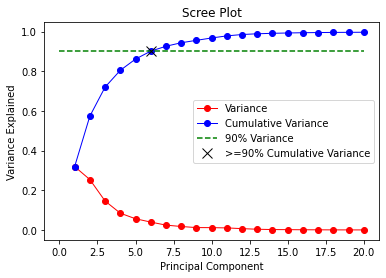

In [37]:
# define PCA model to use on hand coded features
n = 20
pca = PCA(n_components=n)

# fit PCA model
X_train = pca.fit_transform(X_train)
# get cumulative sum of variance and find the dimensions cutoff where we first reach >= 90% variance
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum >= 0.9)[0][0] + 1

# plot scree plot with variance, cumulative variance, and cutoff
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot([0, n], [0.9, 0.9], "g--", label="90% Variance")
plt.plot(cutoff, cum_sum[cutoff - 1], "kx", label=">=90% Cumulative Variance", markersize=10)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

# limit train, val, and test hand coded PCA features up to the first cutoff dimensions
X_train = X_train[:, :cutoff]
X_val = pca.transform(X_val)[:, :cutoff]
X_test = pca.transform(X_test)[:, :cutoff]

In [69]:
np.set_printoptions(linewidth=np.inf)
# Looking at which features contribute most to the first 5 PCA components
ind = np.flip((np.argsort(pca.components_[0:5,:])), axis = 1)

print('Features that contribute the most to 1st PCA component:')
print((X_train_columns[ind[0,:5]]).values)
print('')

print('Features that contribute the most to 2nd PCA component:')
print((X_train_columns[ind[1,:5]]).values)
print('')

print('Features that contribute the most to 3rd PCA component:')
print((X_train_columns[ind[2,:5]]).values)
print('')

print('Features that contribute the most to 4th PCA component:')
print((X_train_columns[ind[3,:5]]).values)
print('')

print('Features that contribute the most to 5th PCA component:')
print((X_train_columns[ind[4,:5]]).values)
print('')

Features that contribute the most to 1st PCA component:
['nut_b_means' 'n_nut_b_means' 'nut_v_means' 'nut_pixs_means' 'n_nut_v_means']

Features that contribute the most to 2nd PCA component:
['sf1' 'sf2' 'average_hue' 'n_shell_s_medians' 'shell_s_medians']

Features that contribute the most to 3rd PCA component:
['sf1' 'ec' 'k' 'shell_b_meds' 'n_shell_b_means']

Features that contribute the most to 4th PCA component:
['major_axes' 'major_axis' 'k' 'ec' 'ellipse_perimeter']

Features that contribute the most to 5th PCA component:
['shell_h_means' 'n_shell_h_means' 'shell_h_medians' 'n_shell_h_medians' 'average_hue']



- We see that the major contributors to the first PCA component are features related to means of the Blue color channel and the Value parameter in the HSV color scale for the pistachio nut.

- Subsequent PCA components contain features related to the shell colors the pistachio shape such as shape factors, eccentricity, aspect ratio and major and minor axis.

- This is expected because we see a large variance in the colors of the pistachio nuts, including some pistachios where the nut is not visible in the image. Some variance is seen in the shell colors, ranging from a bright white to a dull gray. The parameters of the fitted ellipse, in comparison, do not have as much variance across pistachios.

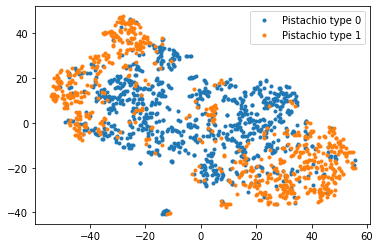

In [82]:
# use tSNE to plot hand coded train features after PCA dimensionality reduction in 2D
tsne = TSNE(n_components=2, random_state=0)
# rescale train PCA data so tSNE can treat dimensions with equal importance
tsne_X = tsne.fit_transform(scaler.fit_transform(X_train))
# plot tSNE of rescaled train PCA data
tsne_plot_x = tsne_X[:, 0]
tsne_plot_y = tsne_X[:, 1]
check_x_0 = tsne_plot_x[y_train == 0]
check_y_0 = tsne_plot_y[y_train == 0]
check_x_1 = tsne_plot_x[y_train == 1]
check_y_1 = tsne_plot_y[y_train == 1]
plt.plot(check_x_0, check_y_0, ".", label = 'Pistachio type 0')
plt.plot(check_x_1, check_y_1, ".", label = 'Pistachio type 1')
plt.legend()

- From the TSNE visualization of the first 6 PCA components, we see that there is some degree of separation between the two classes. Pistachio type 0 tends to be near the center of the plot while, pistachio type 1 tends to be at the either ends, though there is an appreciable overlap. There is also an interesting cluster of both classes at location ~(-12, -40) outside the general population.

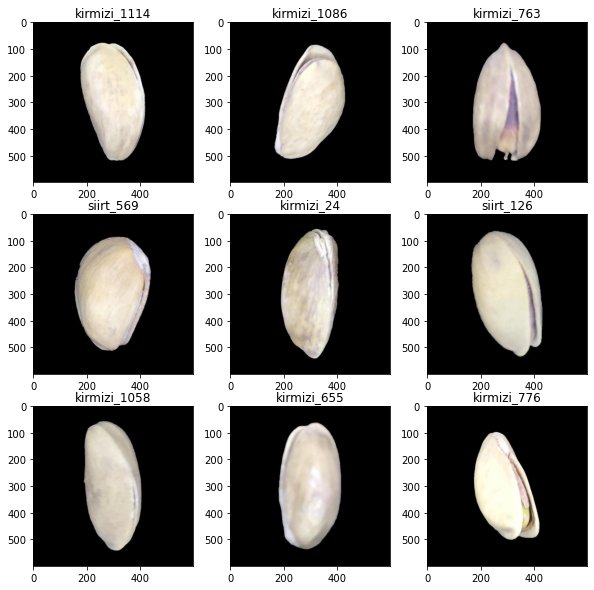

In [150]:
# Looking at 9 pistachios that end up closest to (-12, -40) in the tsne plot

tsne_coords = np.vstack([tsne_plot_x, tsne_plot_y])

pt = [-12, -40]

kdtree_ind = spatial.KDTree(tsne_coords.T).query(pt, k = 9)[1]

# Display examples images
fig, ax = plt.subplots(len(kdtree_ind)//3,3, figsize = (10, 10))

for j in range(0, 9, 3):
    
    ax[j//3, 0].imshow(images[kdtree_ind[j]])
    ax[j//3, 0].set_title(csv.filename_camelcase[kdtree_ind[j]][:-4])
    
    ax[j//3, 1].imshow(images[kdtree_ind[j+1]])
    ax[j//3, 1].set_title(csv.filename_camelcase[kdtree_ind[j+1]][:-4])
    
    ax[j//3, 2].imshow(images[kdtree_ind[j+2]])
    ax[j//3, 2].set_title(csv.filename_camelcase[kdtree_ind[j+2]][:-4])   
 

- It is difficult to see any clear characteristic of these outliers. Each one shows high variation in shell color, which might be the possible cause, but needs further investigation.

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# init and fit logistic regression model to train PCA data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# print training and validation scores and classification metrics
training_score = logreg.score(X_train, y_train)
validation_score = logreg.score(X_val, y_val)
print('Accuracy of logistic regression classifier on validation set: {:.3f} (training {:.3f})'.format(validation_score, training_score))
y_pred = logreg.predict(X_val)
print(metrics.classification_report(y_val, y_pred))

Accuracy of logistic regression classifier on validation set: 0.814 (training 0.839)
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       238
           1       0.75      0.79      0.76       149

    accuracy                           0.81       387
   macro avg       0.80      0.81      0.81       387
weighted avg       0.82      0.81      0.81       387



In [154]:
y_pred == y_val

493      True
345     False
378      True
786      True
197      True
        ...  
1835    False
202     False
1549     True
519      True
1270    False
Name: pistachio_type, Length: 387, dtype: bool

In [152]:
from sklearn import svm
# init and fit rbf svc model to train PCA data
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

# print training and validation scores and classification metrics
training_score = clf.score(X_train, y_train)
validation_score = clf.score(X_val, y_val)
print('Accuracy of rbf svm classifier on validation set: {:.3f} (training {:.3f})'.format(validation_score, training_score))
y_pred = clf.predict(X_val)
print(metrics.classification_report(y_val, y_pred))

Accuracy of rbf svm classifier on validation set: 0.855 (training 0.868)
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       238
           1       0.82      0.81      0.81       149

    accuracy                           0.86       387
   macro avg       0.85      0.85      0.85       387
weighted avg       0.85      0.86      0.86       387



In [25]:
# combine hand coded PCA features with cnn PCA features after both had dimensions reduced
X_train_with_cnn = np.hstack([X_train, X_train_cnn])
X_val_with_cnn = np.hstack([X_val, X_val_cnn])
X_test_with_cnn = np.hstack([X_test, X_test_cnn])

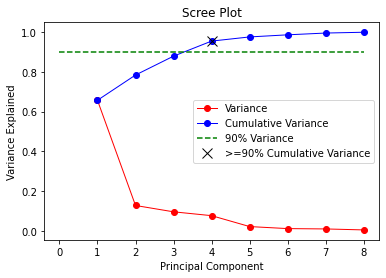

In [26]:
# use standard scaler to rescale by running fit and transform cnn train features
X_train_cnn = scaler.fit_transform(X_train_cnn)
# apply the same transform to val and test
X_val_cnn = scaler.transform(X_val_cnn)
X_test_cnn = scaler.transform(X_test_cnn)

# define PCA model to use on cnn features
n = 8
pca = PCA(n_components=n)

# fit PCA model
X_train_cnn = pca.fit_transform(X_train_cnn)
# get cumulative sum of variance and find the dimensions cutoff where we first reach >= 90% variance
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum >= 0.9)[0][0] + 1

# plot scree plot with variance, cumulative variance, and cutoff
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot([0, n], [0.9, 0.9], "g--", label="90% Variance")
plt.plot(cutoff, cum_sum[cutoff - 1], "kx", label=">=90% Cumulative Variance", markersize=10)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

# limit train, val, and test cnn PCA features up to the first cutoff dimensions
X_train_cnn = X_train_cnn[:, :cutoff]
X_val_cnn = pca.transform(X_val_cnn)[:, :cutoff]
X_test_cnn = pca.transform(X_test_cnn)[:, :cutoff]

### Classification

### Discussion

### Conclusions and Future work(?)

## References

[1] Pistachio Image Dataset https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset

[2] SINGH D, TASPINAR YS, KURSUN R, CINAR I, KOKLU M, OZKAN IA, LEE H-N., (2022). Classification and Analysis of Pistachio Species with Pre-Trained Deep Learning Models, Electronics, 11 (7), 981. https://doi.org/10.3390/electronics11070981. (Open Access)